# Figure 3: Ensemble epistasis depends on differential effects of mutations

## Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

## Functions

In [2]:
def en(dG_j,dG_k,T,R=0.001987):
    """
    Boltzmann-weighted free energy of conformations j and k.
    
    dG_j: stability of conformation j
    dG_k: stability of conformation k
    T: temperature (K)
    R: gas constant (kcal/K*mol)"""
    
    RT = R*T

    return -RT*np.log(np.exp(-dG_j/RT) + np.exp(-dG_k/RT))


def get_epistasis(dG_i,dG_j,dG_k,             
                  ddG_i_A,ddG_j_A,ddG_k_A,
                  ddG_i_B,ddG_j_B,ddG_k_B,
                  T=298,R=0.001987):
    """
    Return the epistasis in dG_obs between two mutations introduced into a
    three-conformation system. 
    
    dG_i, dG_j, dG_k: dG of conformations i, j, and k for genotype ab
    ddG_i_A, ddG_j_A, ddG_k_A: effect of mutation A on conformations i, j, and k
    ddG_i_B, ddG_j_B, ddG_k_B: effect of mutation B on conformations i, j, and k
    T: temperature
    R: gas constant
    
    returns:
        magnitude of epistasis (sign is (AB - aB) - (Ab - ab))
        whether sign in A (True,False)
        whether sign in B (Ture,False)
        type of epistasis as a string (none, magnitude, sign, reciprocal_sign)
    """
    
    # observables
    ab = dG_i                     - en(dG_j,                    dG_k,                    T,R)
    Ab = dG_i + ddG_i_A           - en(dG_j + ddG_j_A,          dG_k + ddG_k_A,          T,R)
    aB = dG_i +           ddG_i_B - en(dG_j +           ddG_j_B,dG_k +           ddG_k_B,T,R)
    AB = dG_i + ddG_i_A + ddG_i_B - en(dG_j + ddG_j_A + ddG_j_B,dG_k + ddG_k_A + ddG_k_B,T,R)
 
    # magnitude
    mag_in_a = (AB - aB) - (Ab - ab)
    mag_in_b = (AB - Ab) - (aB - ab)
    if mag_in_a == 0:
        return mag_in_a, mag_in_b, False, False, "none"

    ep_type = "magnitude"
    
    # sign in A
    s1 = (AB - aB)/np.abs(AB - aB)
    s2 = (Ab - ab)/np.abs(Ab - ab)
    sign_in_a = False
    if s1 != s2:
        ep_type = "sign"
        sign_in_a = True
    
    # sign in B
    s1 = (AB - Ab)/np.abs(AB - Ab)
    s2 = (aB - ab)/np.abs(aB - ab)
    sign_in_b = False
    if s1 != s2:
        ep_type = "sign"
        sign_in_b = True
    
    # reciprocal
    if sign_in_a and sign_in_b:
        ep_type = "reciprocal_sign"
    
    return mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type
    

In [3]:
def plot_surface(some_array,x_array,y_array,flip_color=True,max_value=None,cmap="bwr",
                 xlabel=None,ylabel=None):
    """
    Plot a contour map.
    
    some_array: n x m 2D array
    x_array: array with (at least) [min_x,max_x]
    y_array: array with (at least) [min_y,max_y]
    flip_color: whether or not to flip values in some_array before plotting
    max_value: set min and max color to -max_value and +max_value
        None: get max_value from the array by max(abs(some_array))
        float: use abs(max_value) given
    cmap: matplotlib color map to use
    xlabel: x label
    ylabel: y label
    """

    # Flip color
    if flip_color:
        plot_array = -some_array

    else:
        plot_array = some_array
    
    # Set max color
    if max_value is None:
        extreme = np.max(np.abs(plot_array))

    else:
        extreme = np.abs(max_value)
    print(extreme)
        
    # Plot it
    plt.imshow(plot_array,
               cmap=cmap,origin="lower",vmin=-extreme,vmax=extreme,
               extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],],
               interpolation="none")
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
        
        
def _plot_states(dG_j,dG_k,
                 ddG_j=None,ddG_k=None,
                 observable=0,
                 x_location=0,arrow_colors=None):
    """
    Draw conformation energies and effects of mutations for a given genotype.
    
    dG_j: stability of conformation j before mutation
    dG_k: stability of conformation k before mutation
    ddG_j: effect of mutations to conformation j.  
           If None, no mutations.
           If float, single mutation (one arrow).
           If list of floats, multiple mutations (each with own arrow)
    ddG_k: effect of mutations to conformation k.  (Same syntax as ddG_j).
    observable: observable <dGjk>
    x_location: where to draw states on total plot.
    arrow_colors: color to draw each arrow.
                  If None, all arrows black.
                  Otherwise, must be a list of colors, in order.  Arrows are
                  plotted in order ddG_j, then ddG_k.   
    """

    # x-placement for edges of genotypes
    x0 = 0
    x1 = 2
    x2 = 2.5
    x3 = 4.5

    # If ddG_j specified, add dashed line for dG_j
    if ddG_j is None:
        ddG_j = 0
    else:        
        plt.plot([x0+x_location,x1+x_location],[dG_j,dG_j],"--",lw=2,color="purple",zorder=10)

    # If ddG_k specified, add dashed line for dG_k
    if ddG_k is None:
        ddG_k = 0
    else:        
        plt.plot([x2+x_location,x3+x_location],[dG_k,dG_k],"--",lw=2,color="blue",zorder=10)
    
    # If ddG_j is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_j)
        total_ddG_j = sum(ddG_j)
    except TypeError:
        total_ddG_j = ddG_j
        ddG_j = [ddG_j,]

    # If ddG_k is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_k)
        total_ddG_k = sum(ddG_k)
    except TypeError:
        total_ddG_k = ddG_k
        ddG_k = [ddG_k,]
    
    # Plot energy levels
    plt.plot([x0+x_location,x1+x_location],[dG_j+total_ddG_j,dG_j+total_ddG_j],lw=2,color="purple",zorder=10)
    plt.plot([x2+x_location,x3+x_location],[dG_k+total_ddG_k,dG_k+total_ddG_k],lw=2,color="blue",zorder=10)
    
    # Plot observable
    plt.plot([x0+x_location,x3+x_location],[observable,observable],lw=4,color="black",zorder=0)
    
    # Count through arrow colors
    color_counter = 0
    
    current = dG_j
    for counter, j_arrow in enumerate(ddG_j):
        
        # If this ddG is 0, do not draw an arrow
        if j_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x0 + (x1 - x0)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = j_arrow/np.abs(j_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,j_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + j_arrow
        color_counter += 1
        
    current = dG_k
    for counter, k_arrow in enumerate(ddG_k):
        
        # If this ddG is 0, do not draw an arrow
        if k_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x2 + (x3 - x2)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = k_arrow/np.abs(k_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,k_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + k_arrow
        color_counter += 1
        

    

def plot_state_cycle(dG_j=0,dG_k=0,
                     ddG_Aj=-4,ddG_Ak=4,
                     ddG_Bj=-4,ddG_Bk=4,
                     T=298,R=0.001987,
                     ylim=(-14,14)):
    """
    dG_j: stability of conformation j, ab genotype
    dG_k: stability of conformation k, ab genotype
    ddG_Aj: effect of mutation A on conformation j
    ddG_Ak: effect of mutation A on conformation k
    ddG_Bj: effect of mutation B on conformation j
    ddG_Bk: effect of mutation B on conformation k
    T: temperature (K)
    R: gas constant
    y_lim: y-limits of plot
    """
    
    # Calculate observables for ab, Ab, aB, and AB genotypes
    RT = R*T
    
    ab = en(dG_j                  , dG_k,                  T,R)
    Ab = en(dG_j + ddG_Aj         , dG_k + ddG_Ak,         T,R)
    aB = en(dG_j          + ddG_Bj, dG_k          + ddG_Bk,T,R)
    AB = en(dG_j + ddG_Aj + ddG_Bj, dG_k + ddG_Ak + ddG_Bk,T,R)
    
    # print relative populations
    print('ab, j: ' , np.exp(-dG_j)/(np.exp(-dG_j) + np.exp(-dG_k)))
    print('ab, k: ' , np.exp(-dG_k)/(np.exp(-dG_j) + np.exp(-dG_k)))
    
    print('Ab, j: ' , np.exp(-(dG_j + ddG_Aj))/(np.exp(-(dG_j + ddG_Aj)) + np.exp(-(dG_k + ddG_Ak))))
    print('Ab, k: ' , np.exp(-(dG_k + ddG_Ak))/(np.exp(-(dG_j + ddG_Aj)) + np.exp(-(dG_k + ddG_Ak))))
    
    print('aB, j: ' , np.exp(-(dG_j + ddG_Bj))/(np.exp(-(dG_j + ddG_Bj)) + np.exp(-(dG_k + ddG_Bk))))
    print('aB, k: ' , np.exp(-(dG_k + ddG_Bk))/(np.exp(-(dG_j + ddG_Bj)) + np.exp(-(dG_k + ddG_Bk))))

    print('AB, j: ' , np.exp(-(dG_j + ddG_Aj + ddG_Bj))/(np.exp(-(dG_j + ddG_Aj + ddG_Bj)) + np.exp(-(dG_k + ddG_Ak +  ddG_Bk))))
    print('AB, k: ' , np.exp(-(dG_k + ddG_Ak + ddG_Bk))/(np.exp(-(dG_j + ddG_Aj + ddG_Bj)) + np.exp(-(dG_k + ddG_Ak +  ddG_Bk))))

    
    #print(dG_j-dG_k,ddG_Aj-ddG_Ak,(AB-aB)-(Ab-ab))
    
    # Plot states for each genotype, offseting by x_location for each one
    _plot_states(dG_j,dG_k,observable=ab,x_location=0)
    _plot_states(dG_j,dG_k,[ddG_Aj],[ddG_Ak],observable=Ab,x_location=6,arrow_colors=["orange","orange"])
    _plot_states(dG_j,dG_k,[ddG_Bj],[ddG_Bk],observable=aB,x_location=12,arrow_colors=["green","green"])
    _plot_states(dG_j,dG_k,[ddG_Bj,ddG_Aj],[ddG_Bk,ddG_Ak],observable=AB,x_location=18,arrow_colors=["green","orange","green","orange"])
    
    # Print epistasis
    print("Ab-ab:",Ab-ab)
    print("AB-ab:",AB-aB)
    print("Epistasis:",(AB-aB)-(Ab-ab))
    
    plt.ylim(*ylim)

# Panel 3A: Epistasis parameter space (differential effects of mutations)

1.594680762276131


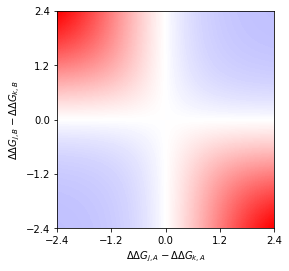

In [4]:
R = 0.001987
T = 298.0

dG_i = 0
ddG_i_A = 0
ddG_i_B = 0

dG_j = 0
ddG_j_A = 0
ddG_j_B = 0

dG_k = 0
ddG_k_A = 0
ddG_k_B = 0

split_step_size = 0.01
split_min_value = -2.39006
split_max_value = 2.39006
split_values = np.arange(split_min_value,split_max_value+split_step_size,split_step_size)

output = np.zeros((len(split_values),len(split_values)),dtype=np.float)
reciprocal_output = np.zeros((len(split_values),len(split_values)),dtype=str)

for x in range(len(split_values)):
    
    # set mutation_A perturb
    ddG_j_A_this = ddG_j_A - split_values[x]/2
    ddG_k_A_this = ddG_k_A + split_values[x]/2
    
    for y in range(len(split_values)):
        
        # set mutation_B perturb
        ddG_j_B_this = ddG_j_B - split_values[y]/2
        ddG_k_B_this = ddG_k_B + split_values[y]/2
        
        mag_in_a, mag_in_b, sign_in_a, sign_in_b, ep_type = get_epistasis(dG_i,dG_j,dG_k,             
                                                                          ddG_i_A,ddG_j_A_this,ddG_k_A_this,
                                                                          ddG_i_B,ddG_j_B_this,ddG_k_B_this,
                                                                          T,R)   


        reciprocal_output[y,x] = ep_type
        output[y,x] = mag_in_a

plot_surface(output,split_values,split_values,
             xlabel="$ \Delta \Delta G_{j,A} - \Delta \Delta G_{k,A}$",
             ylabel="$ \Delta \Delta G_{j,B} - \Delta \Delta G_{k,B}$",)

plt.xlim(-2.4,2.4)
plt.xticks(np.arange(-2.4, 2.5, 1.2))
plt.yticks(np.arange(-2.4, 2.5, 1.2))

#plt.savefig('fig-3a.pdf')
plt.show()

None

## Identify reciprocal sign regions in Panel 3A plot above

C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `a

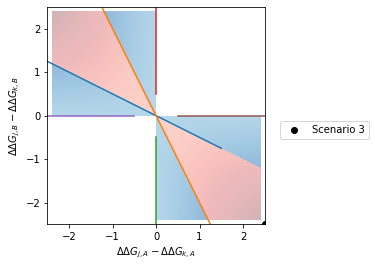

In [6]:
"""
Plot a contour map.

some_array: n x m 2D array
x_array: array with (at least) [min_x,max_x]
y_array: array with (at least) [min_y,max_y]
flip_color: whether or not to flip values in some_array before plotting
max_value: set min and max color to -max_value and +max_value
    None: get max_value from the array by max(abs(some_array))
    float: use abs(max_value) given
cmap: matplotlib color map to use
xlabel: x label
ylabel: y label
"""
rmask = [reciprocal_output == ['m']]
mask2 = [reciprocal_output == ['s']]
output_masked = np.copy(output)
output_masked[rmask] = np.nan

output_masked[mask2] = np.nan



smask = [reciprocal_output == ['m']]
smask2 = [reciprocal_output == ['r']]
output_masked_m = np.copy(output)
output_masked_m[smask] = np.nan
output_masked_m[smask2] = np.nan



cmap = "bwr"
xlabel = "$ \Delta \Delta G_{j,A} - \Delta \Delta G_{k,A}$"
ylabel = "$ \Delta \Delta G_{j,B} - \Delta \Delta G_{k,B}$"
flip_color = True
x_array = split_values
y_array = split_values
# Flip color
if flip_color:
    plot_array = -output
    plot_array2 = -output_masked
    plot_array3 = -output_masked_m
    
else:
    plot_array = output
    plot_array2 = output_masked
    plot_array3 = output_masked_m

extreme = np.max(np.abs(plot_array))
extreme2 = np.max(np.abs(plot_array2))

# Plot it
fig, ax = plt.subplots()

## plot reciprocal sign region
ax.imshow(plot_array2,origin = 'lower', 
          vmin=-extreme,vmax=extreme,cmap = 'Reds'
            , extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],]
          , interpolation = 'none', visible = True, alpha = 0.3, label = 'reciprocal sign')

## plot sign epistasis region
ax.imshow(plot_array3,origin = 'lower', 
          vmin=-extreme,vmax=extreme,cmap = 'Blues'
            , extent=[x_array[0],x_array[-1],y_array[0],y_array[-1],]
          , interpolation = 'none', visible = True, alpha = 0.5, label = 'sign')
ax.scatter(2.5,-2.5, marker = 'o', color = 'black', label = 'Scenario 3')


def gety(lo,up,slope):
    
    return np.arange(lo,up)*slope


plt.plot(np.arange(-2.5,2.5), gety(-2.5,2.5,-0.5))
plt.plot(np.arange(-2.5,2.5), gety(-2.5,2.5,-2))

y = np.arange(-2.5,0)
plt.plot([0]*len(y), y)
plt.plot([0]*len(-y), -y)

plt.plot(y, [0]*len(y),)
plt.plot(-y, [0]*len(-y))

#ax.plot(plot_array3[0,0, y_array)
ax.legend(bbox_to_anchor = (1.5,0.5))
if xlabel is not None:
    ax.set_xlabel(xlabel)
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5)
if ylabel is not None:
    ax.set_ylabel(ylabel)

#plt.savefig('param_space_epistasis.pdf')
    


# Panel 3C: No epistasis

ab, j:  0.5
ab, k:  0.5
Ab, j:  0.32805015183202035
Ab, k:  0.6719498481679796
aB, j:  0.5
aB, k:  0.5
AB, j:  0.32805015183202035
AB, k:  0.6719498481679796
Ab-ab: -0.10248407849670876
AB-ab: -0.10248407849670879
Epistasis: -2.7755575615628914e-17


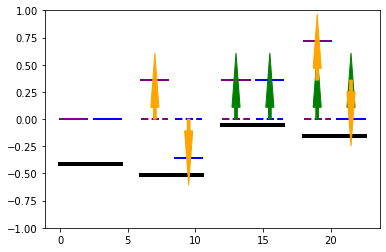

In [9]:
## no epistasis
plot_state_cycle(0,0,1.5/4.184,-1.5/4.184,1.50/4.184,1.50/4.184,ylim = (-1,1))
#plt.savefig("fig3C_scenario-1.pdf")
plt.show()

# Panel 3D: Magnitude epistasis

ab, j:  0.5
ab, k:  0.5
Ab, j:  0.32805015183202035
Ab, k:  0.6719498481679796
aB, j:  0.32805015183202035
aB, k:  0.6719498481679796
AB, j:  0.19247085357487365
AB, k:  0.8075291464251264
Ab-ab: -0.10248407849670876
AB-ab: -0.2544557186149269
Epistasis: -0.15197164011821812


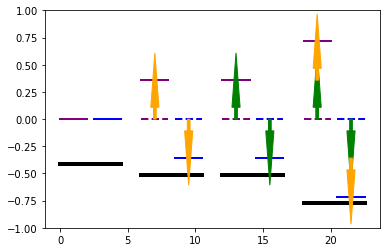

In [10]:
## magnitude epistasis
plot_state_cycle(0,0,1.5/4.184,-1.5/4.184,1.50/4.184,-1.50/4.184,ylim = (-1,1))
#plt.savefig("fig3D_scenario-2.pdf")
plt.show()

# Panel 3E: Reciprocal sign epistasis

ab, j:  0.5
ab, k:  0.5
Ab, j:  0.32805015183202035
Ab, k:  0.6719498481679796
aB, j:  0.6719498481679796
aB, k:  0.32805015183202035
AB, j:  0.5
AB, k:  0.5
Ab-ab: -0.10248407849670876
AB-ab: 0.10248407849670876
Epistasis: 0.20496815699341753


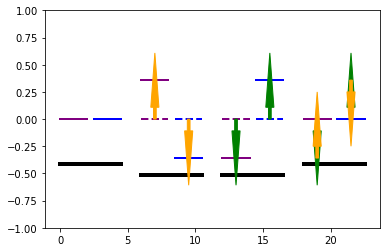

In [11]:
## reciprocal sign episatsis
plot_state_cycle(0,0,1.5/4.184,-1.5/4.184,-1.50/4.184,1.50/4.184,ylim = (-1,1))
#plt.savefig("fig3E_scenario-3.pdf")
plt.show()